In [1]:
import copy, os, sys, time

import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

sys.path.append('../')
from det_rnn import *
import det_rnn.train as utils_train
import det_rnn.analysis as utils_analysis
from det_rnn.train.model import Model
from models.gatedRNN.gatedRNN import gRNN
from models.gatedRNN.gatedRNN_hyper import grnn_hp

from models.base.analysis import behavior_summary, estimation_decision

from utils.plotfnc import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  0


# Generate stimulus, training and test sets
For decision and estimation

In [2]:
print('batchsize = ' + str(par['batch_size']))
par

batchsize = 128


{'design': {'iti': (0, 1.5),
  'stim': (1.5, 3.0),
  'delay': ((3.0, 4.0), (5.5, 6.0)),
  'decision': (4.0, 5.5),
  'estim': (6.0, 7.5)},
 'dm_output_range': 'design',
 'em_output_range': 'design',
 'dead': 'design',
 'mask_dm': {'iti': 1.0,
  'stim': 1.0,
  'decision': 1600.0,
  'delay': 1.0,
  'estim': 1.0,
  'rule_iti': 2.0,
  'rule_stim': 2.0,
  'rule_decision': 3200.0,
  'rule_delay': 2.0,
  'rule_estim': 2.0},
 'mask_em': {'iti': 1.0,
  'stim': 1.0,
  'decision': 1.0,
  'delay': 1.0,
  'estim': 200.0,
  'rule_iti': 2.0,
  'rule_stim': 2.0,
  'rule_decision': 2.0,
  'rule_delay': 2.0,
  'rule_estim': 400.0},
 'input_rule': 'design',
 'output_dm_rule': 'design',
 'output_em_rule': 'design',
 'input_rule_strength': 0.8,
 'output_dm_rule_strength': 0.8,
 'output_em_rule_strength': 0.8,
 'reference': [-4, -3, -2, -1, 1, 2, 3, 4],
 'strength_ref': 1.0,
 'type': 'orientation',
 'stim_dist': 'uniform',
 'natural_a': 0.0002,
 'ref_dist': 'uniform',
 'trial_per_subblock': 1,
 'stim_encodin

In [3]:
# training set
par_train = copy.deepcopy(par)
par_train['n_ori'] = 24
par_train = update_parameters(par_train)
stim_train = Stimulus(par_train)

# generate training data
train_data = stim_train.generate_trial()

orientation = 67.5, reference = 52.5


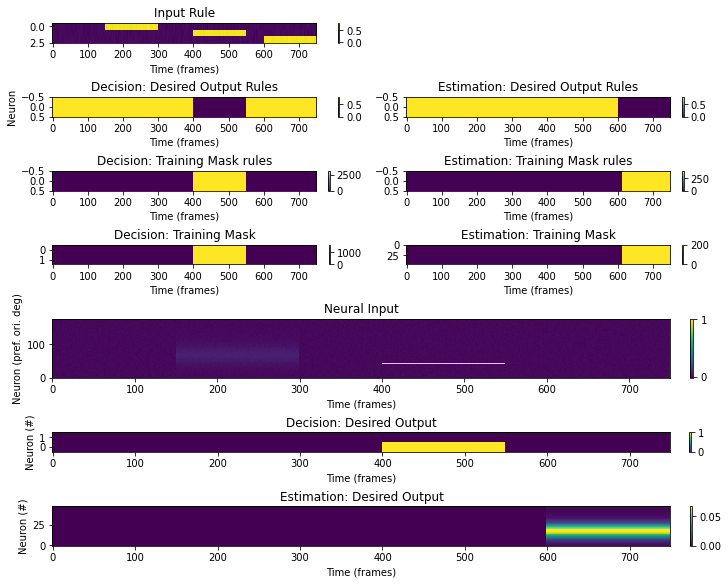

In [4]:
# check stimulus
random_trial_num = np.random.randint(stim_train.batch_size)
target_ori = np.arange(0,180,180/par_train['n_ori'])[train_data['stimulus_ori'][random_trial_num]]
ref_ori = np.arange(0,180,180/par_train['n_tuned_input'])[train_data['ref_neuron'][random_trial_num]]
print('orientation = ' + str(target_ori) + ', reference = ' + str(ref_ori))
plot_trial(train_data, stim_train, TEST_TRIAL=random_trial_num)

In [5]:
# set up a new test data with more batch
par_test                        = copy.deepcopy(par)
par_test['n_ori']               = 24
par_test['batch_size']          = 5000 # at least 9 refs * 24 orientations
par_test['reference']           = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
par_test                        = update_parameters(par_test)
stim_test                       = Stimulus(par_test)
test_data                       = stim_test.generate_trial()

# set up network


In [6]:
grnn_hp = grnn_hp(par_train)
grnn = gRNN(grnn_hp, par_train)

In [7]:
# untrained network behavior
test_data                       = stim_train.generate_trial()
test_lossStruct, test_outputs   = grnn.evaluate(test_data)
est_summary, dec_summary = behavior_summary(test_data, test_outputs, stim_train)

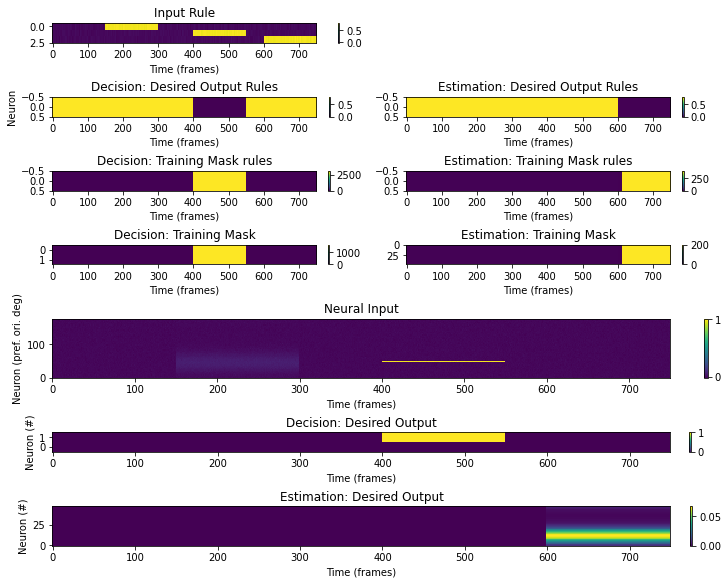

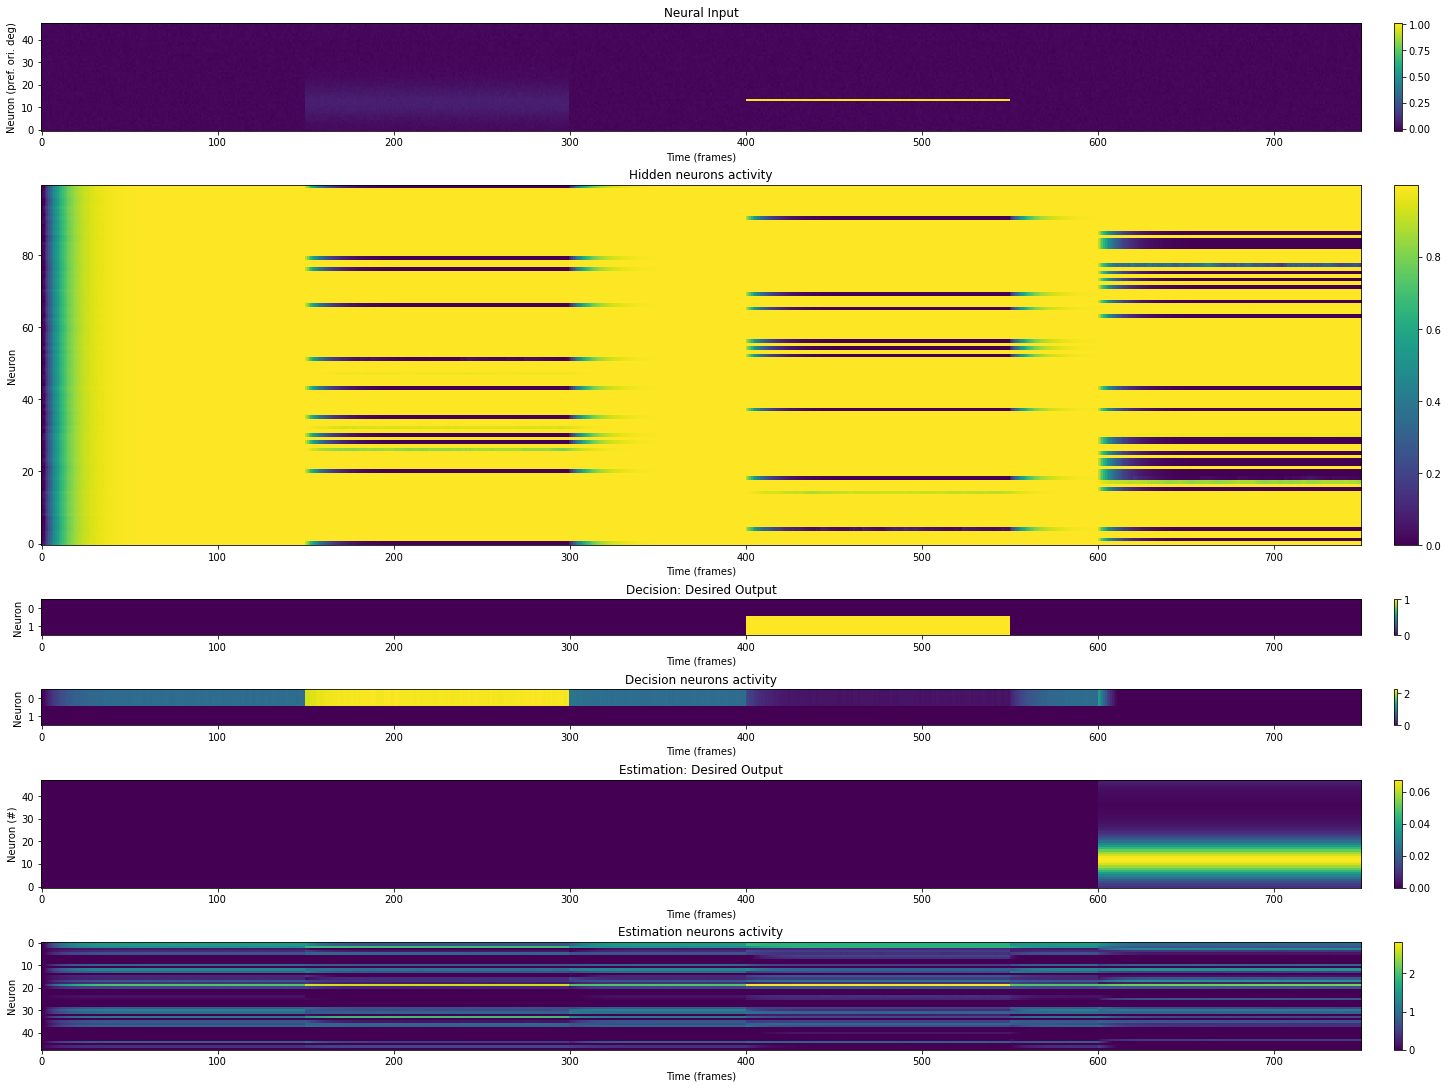

In [8]:
TEST_TRIAL = np.random.randint(stim_train.batch_size) 
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

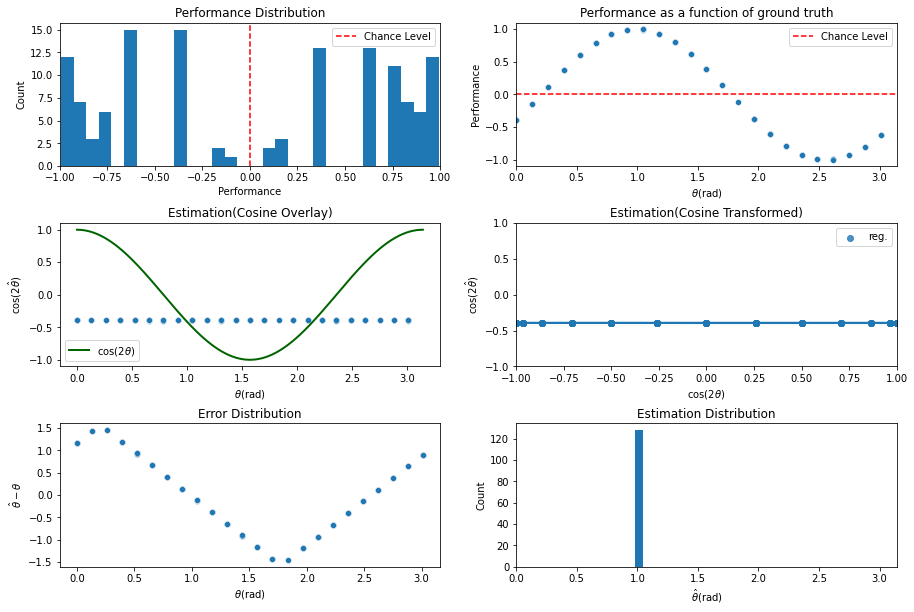

In [9]:
behavior_figure(est_summary)

# Model 9
- No stsp
- relu(tanh()) activation
- gated outputs (dm and em)
- relu output
- no ce loss

In [10]:
grnn_hp

{'output_path': '/Users/JRyu/github/det_rnn/experiments/grnn/model1/',
 'model_output': '/Users/JRyu/github/det_rnn/experiments/grnn/model1/model',
 'log_path': '/Users/JRyu/github/det_rnn/experiments/grnn/model1/logs',
 'saving_freq': 100,
 'dtype': 'tf.float32',
 'loss_mse_dec': 1,
 'loss_mse_est': 1,
 'loss_ce_dec': 1,
 'loss_ce_est': 1,
 'loss_spike': 0.002,
 'loss_L1': 0.01,
 'loss_L2': 0.01,
 'nsteps_train': 5000,
 'learning_rate': 0.02,
 'clip_max_grad_val': 0.1,
 'dt': 10.0,
 'neuron_tau': 100,
 'noise_sd': 0.5,
 'neuron_stsp': False,
 'exc_inh_prop': 0.8,
 'alpha_std': (0.05, 0.00667),
 'alpha_stf': (0.00667, 0.05),
 'U': (0.15, 0.45),
 'n_input': 51,
 'n_tuned_input': 48,
 'n_hidden': 100,
 'n_tuned_output': 48,
 'n_rule_input': 3,
 'n_rule_output_dm': 1,
 'n_rule_output_em': 1,
 'out_gate': True,
 'rnn_gate': True,
 'rnn_weights': 'normal',
 'rnn_weights_shift': 86,
 'rnn_weights_scale': 112,
 'rnn_noise_type': 'Normal_fixed'}

In [11]:
hp9    = copy.deepcopy(grnn_hp)
hp9['output_path'] = '/Users/JRyu/github/det_rnn/experiments/grnn/model9/'
hp9['model_output'] = '/Users/JRyu/github/det_rnn/experiments/grnn/model9/model'
hp9['log_path'] = '/Users/JRyu/github/det_rnn/experiments/grnn/model9/logs'
hp9['learning_rate'] = 0.05
hp9['neuron_stsp'] = False
hp9['out_gate'] = True
hp9['loss_ce_dec'] = 100
hp9['loss_ce_est'] = 100
grnn9  = gRNN(hp9, par_train)
# grnn2.train(stim_train = stim_train, stim_test= stim_train, niter=5000)

In [12]:
# load trained network without stsp
# no STSP
#from det_rnn.base.functions import alternating, w_rnn_mask
#from models.gatedRNN.gatedRNN import RNNCell
#model1_path = '/Users/JRyu/github/det_rnn/experiments/grnn/model1/model/iter1/'
#grnn1 = tf.keras.models.load_model(model1_path,
#                                   custom_objects={'RNNCell': RNNCell}, 
#                                   compile=False)

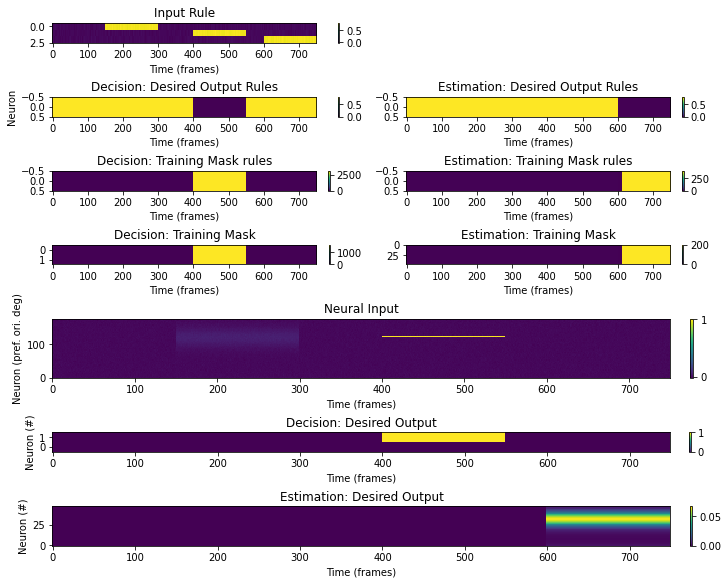

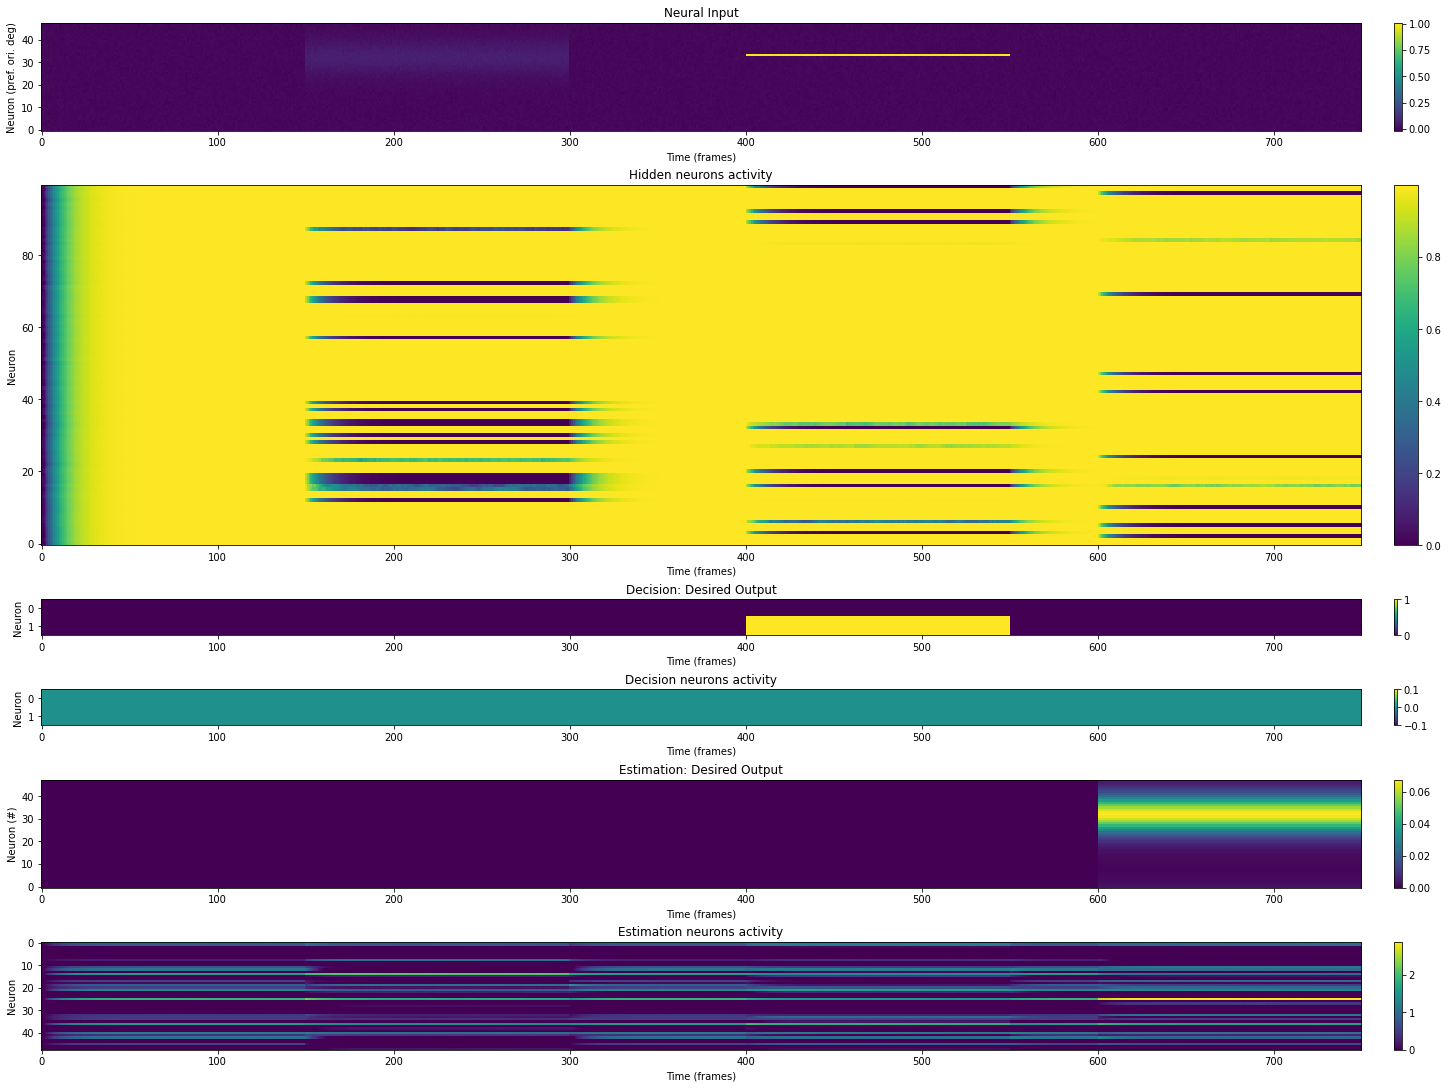

../models/base/analysis.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CW'][0] = False
../models/base/analysis.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CW'][1] = True
../utils/plotfnc.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
../utils/plotfnc.py:485: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


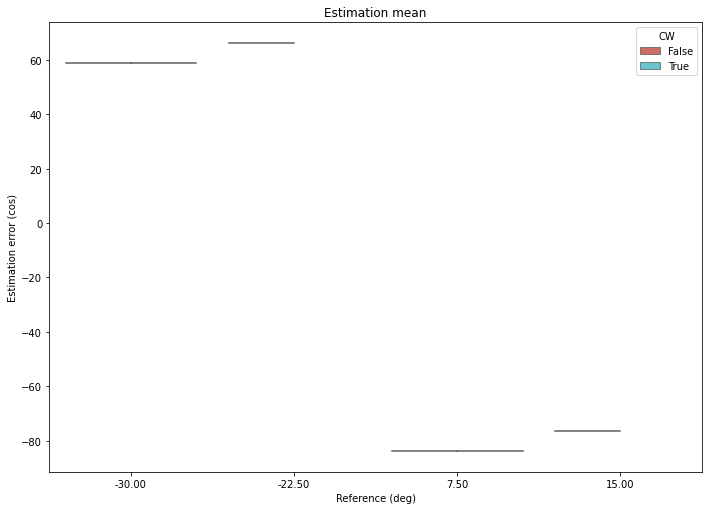

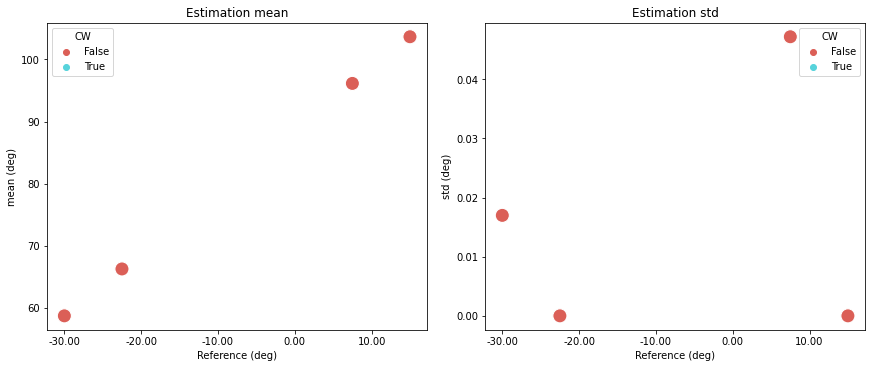

In [13]:
# evaluate and visualize before training
test_lossStruct, test_outputs   = grnn9.evaluate(test_data)

# plot rnn trial and outputs
TEST_TRIAL = np.random.randint(stim_train.batch_size) 
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

# plot rnn decision effects on estimation
df_trials, df_sum = estimation_decision(test_data, test_outputs, stim_test)
plot_decision_effects(df_trials,df_sum)

   1/1000 [..............................] - ETA: 7880s - Train Loss: 486.4034 - Test Loss: 748.6026 - Test estimation cos error: : 0.6862 - Test decision performance: : 0.4062 - Grads: 216.0117


 Epoch 2, Train Loss: 486.4033508300781, Test Loss: 748.6026000976562


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


From /opt/anaconda3/envs/detrnn37/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter1/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter1/assets


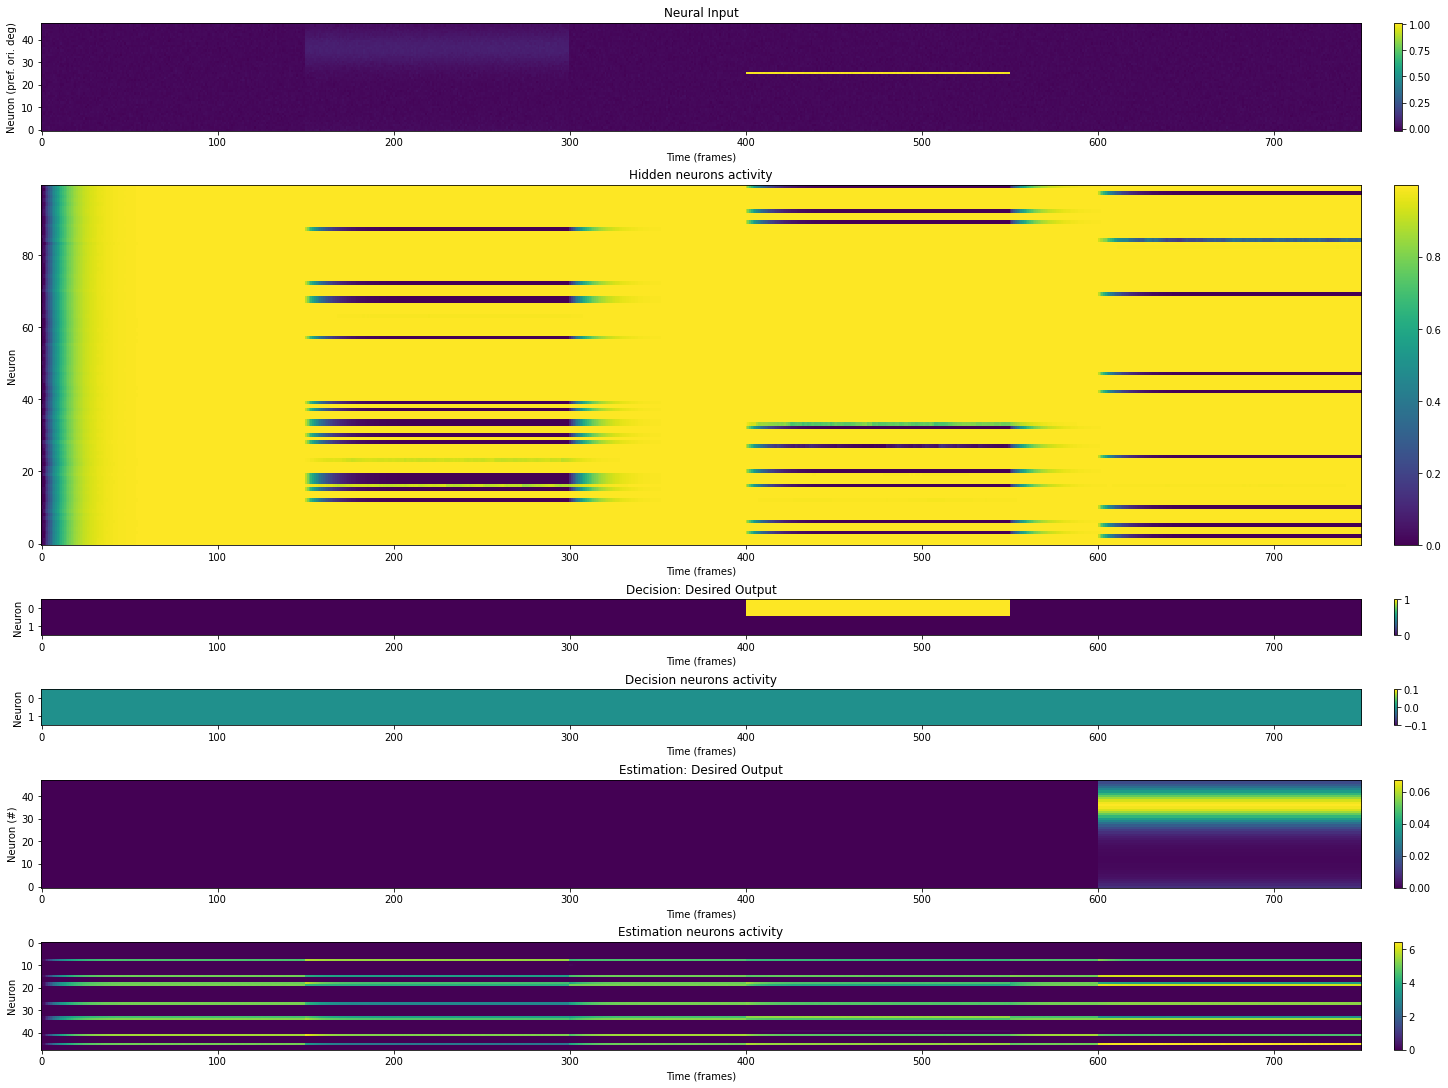

 101/1000 [==>...........................] - ETA: 7657s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6279 - Test decision performance: : 0.5234 - Grads: 0.7598


 Epoch 102, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter101/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter101/assets


<Figure size 432x288 with 0 Axes>

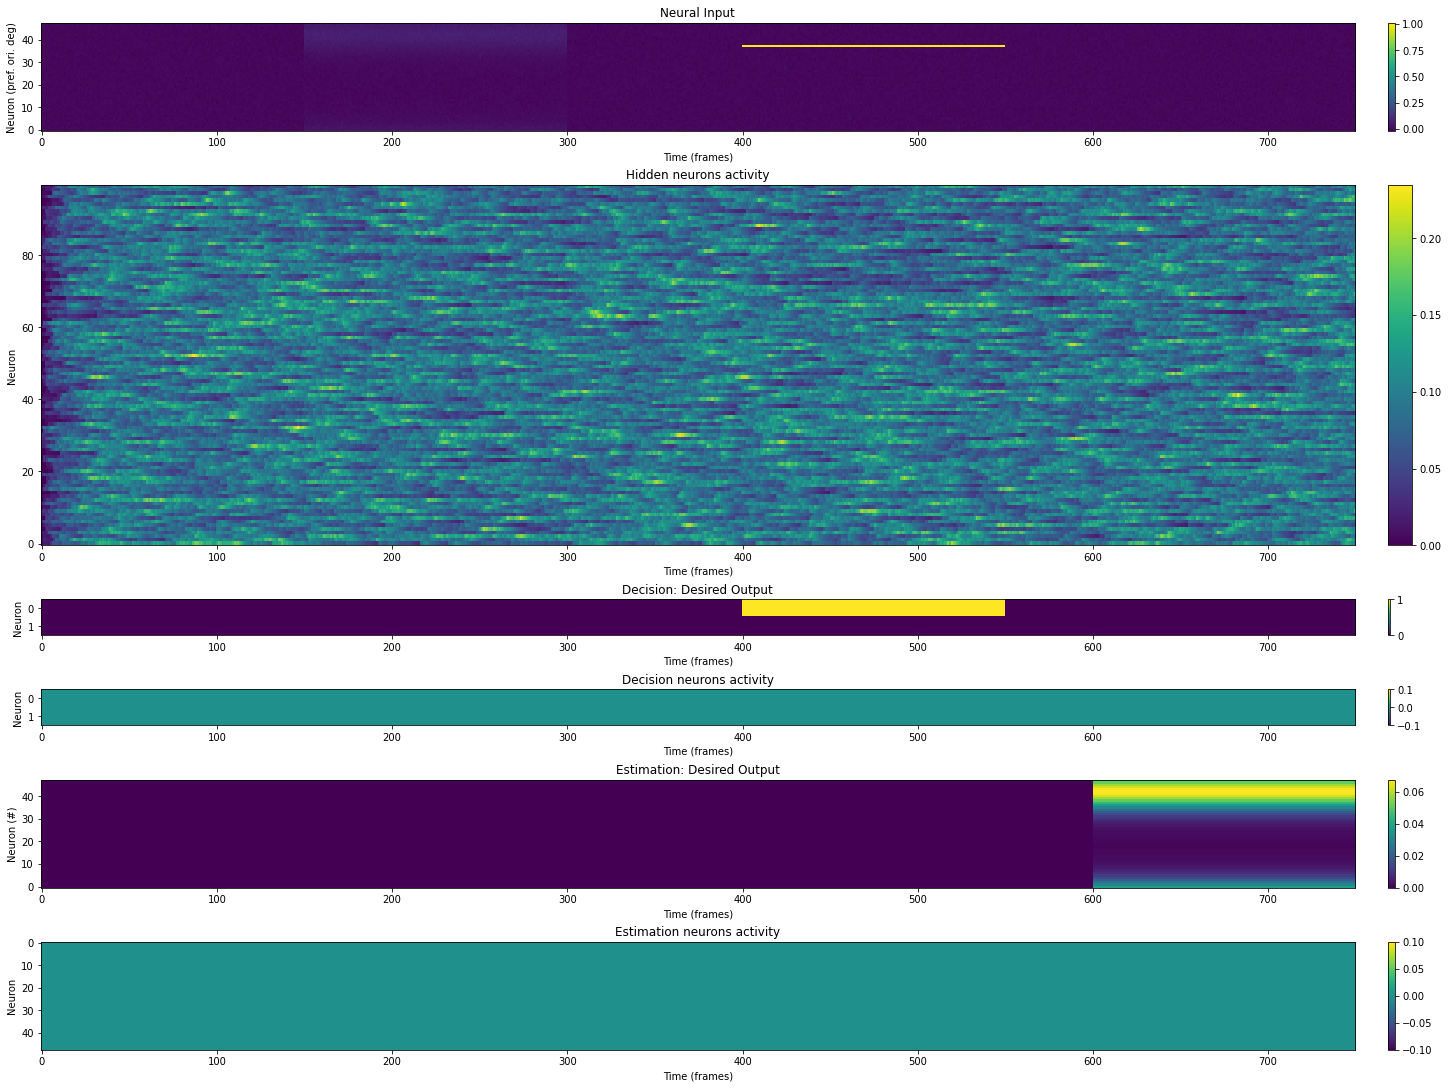

 201/1000 [=====>........................] - ETA: 7244s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.5720 - Test decision performance: : 0.4688 - Grads: 0.7598


 Epoch 202, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter201/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter201/assets


<Figure size 432x288 with 0 Axes>

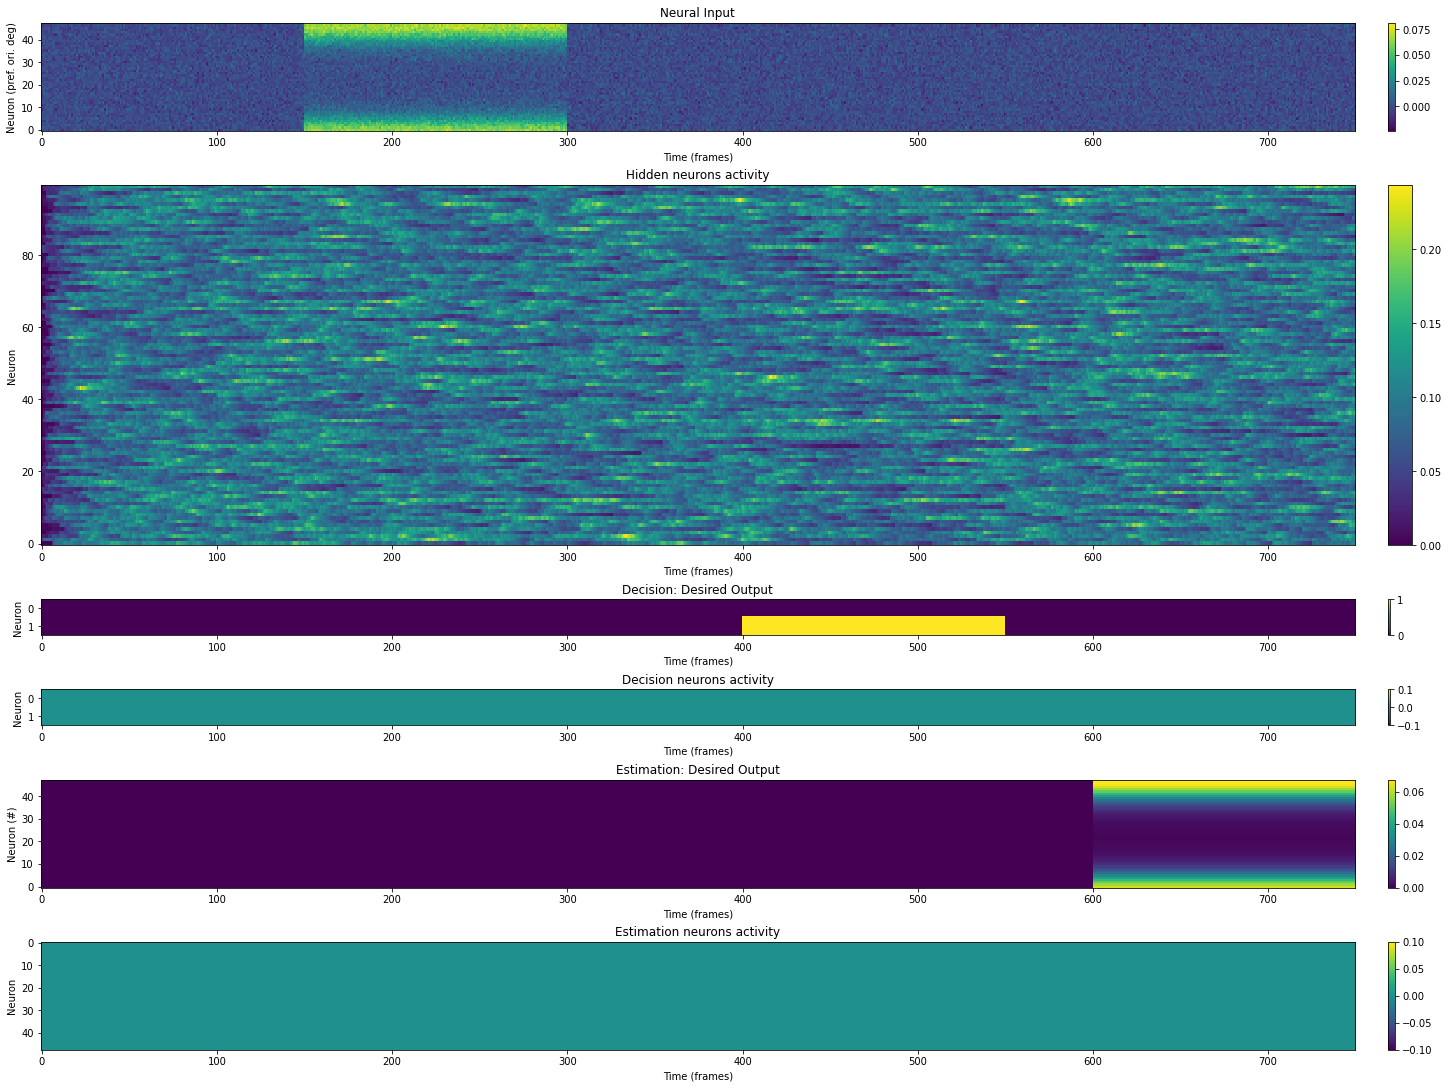

 301/1000 [========>.....................] - ETA: 6081s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6978 - Test decision performance: : 0.4844 - Grads: 0.7598


 Epoch 302, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter301/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter301/assets


<Figure size 432x288 with 0 Axes>

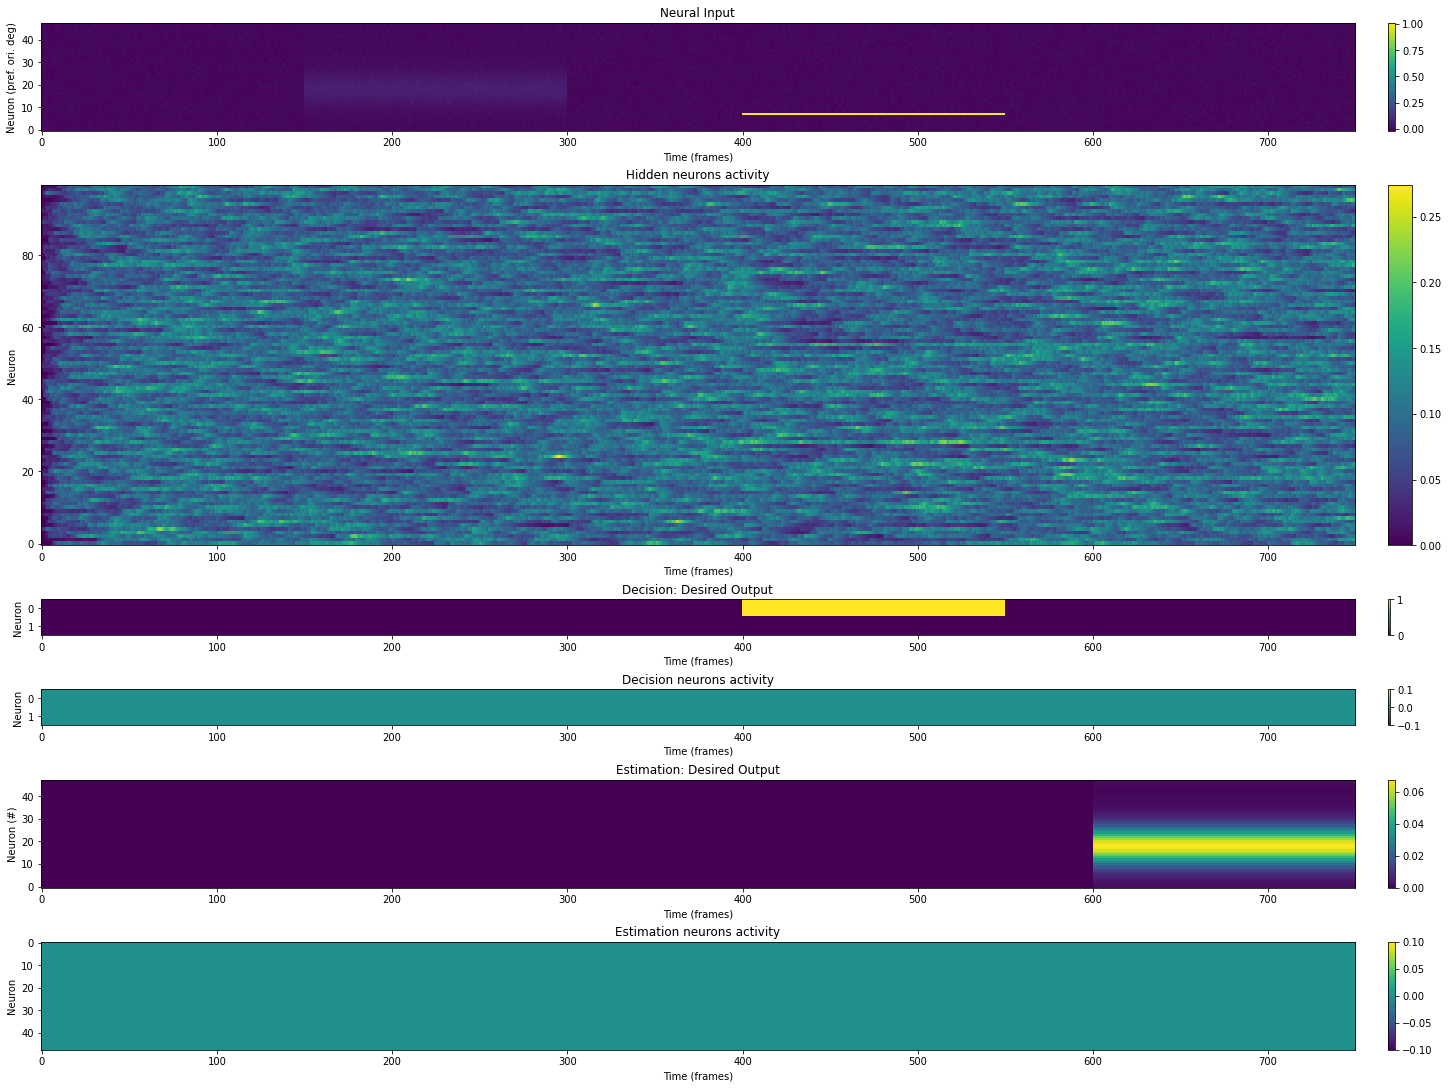

 401/1000 [===========>..................] - ETA: 5388s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6111 - Test decision performance: : 0.4453 - Grads: 0.7597


 Epoch 402, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter401/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter401/assets


<Figure size 432x288 with 0 Axes>

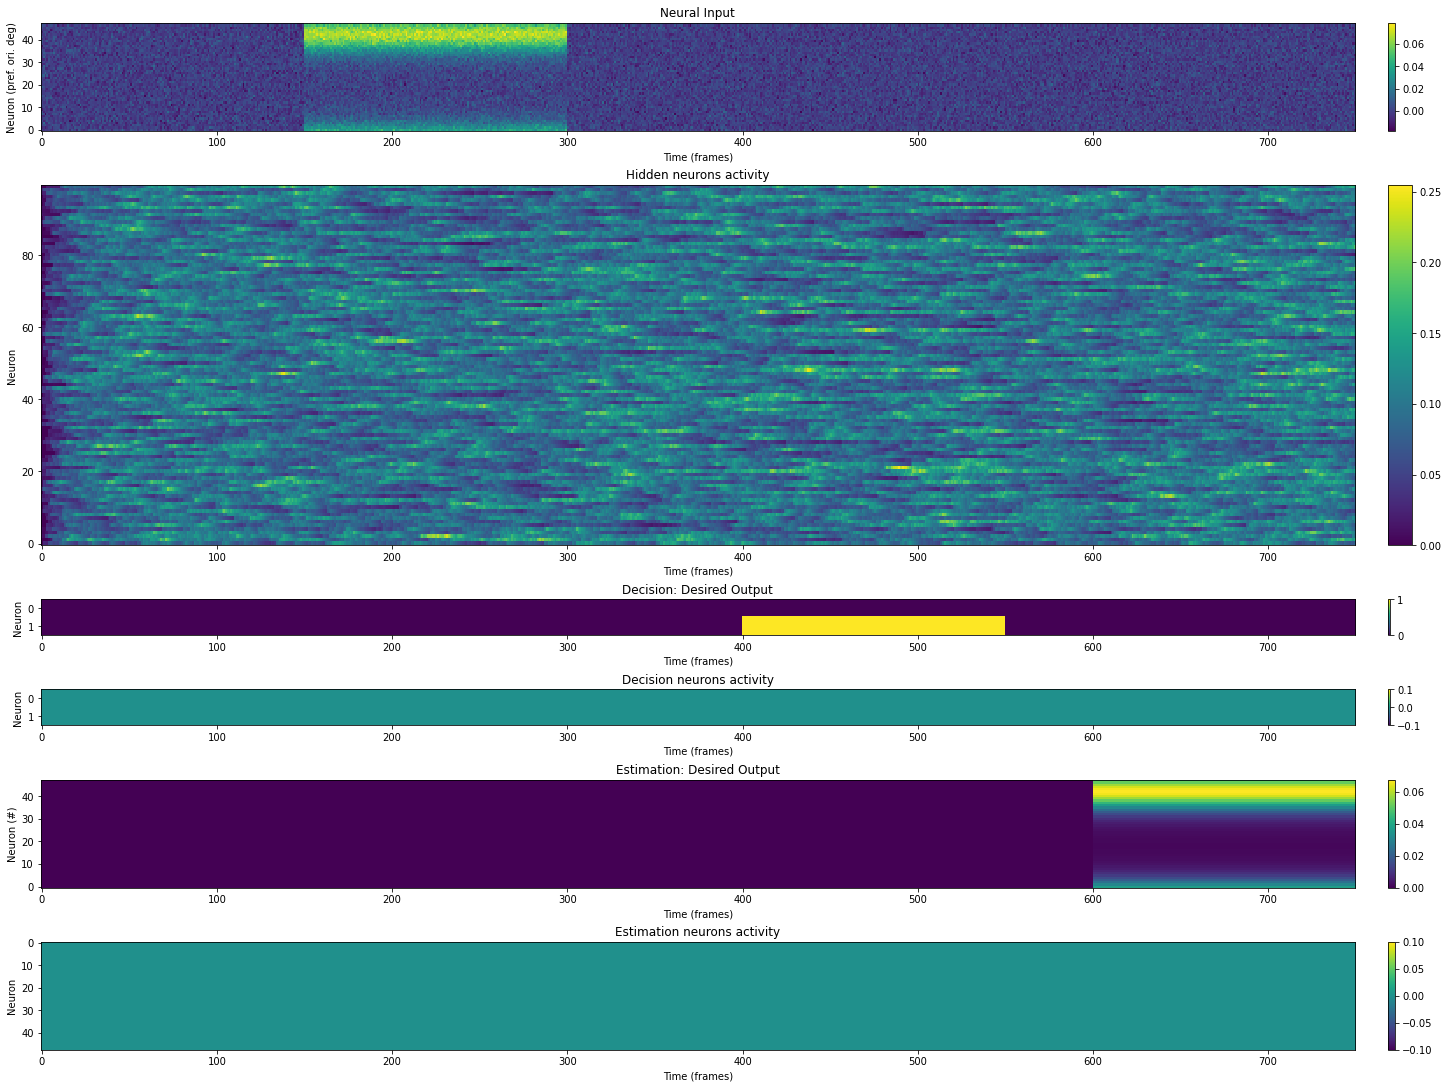

 501/1000 [==============>...............] - ETA: 4707s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6230 - Test decision performance: : 0.4219 - Grads: 0.7597


 Epoch 502, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter501/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter501/assets


<Figure size 432x288 with 0 Axes>

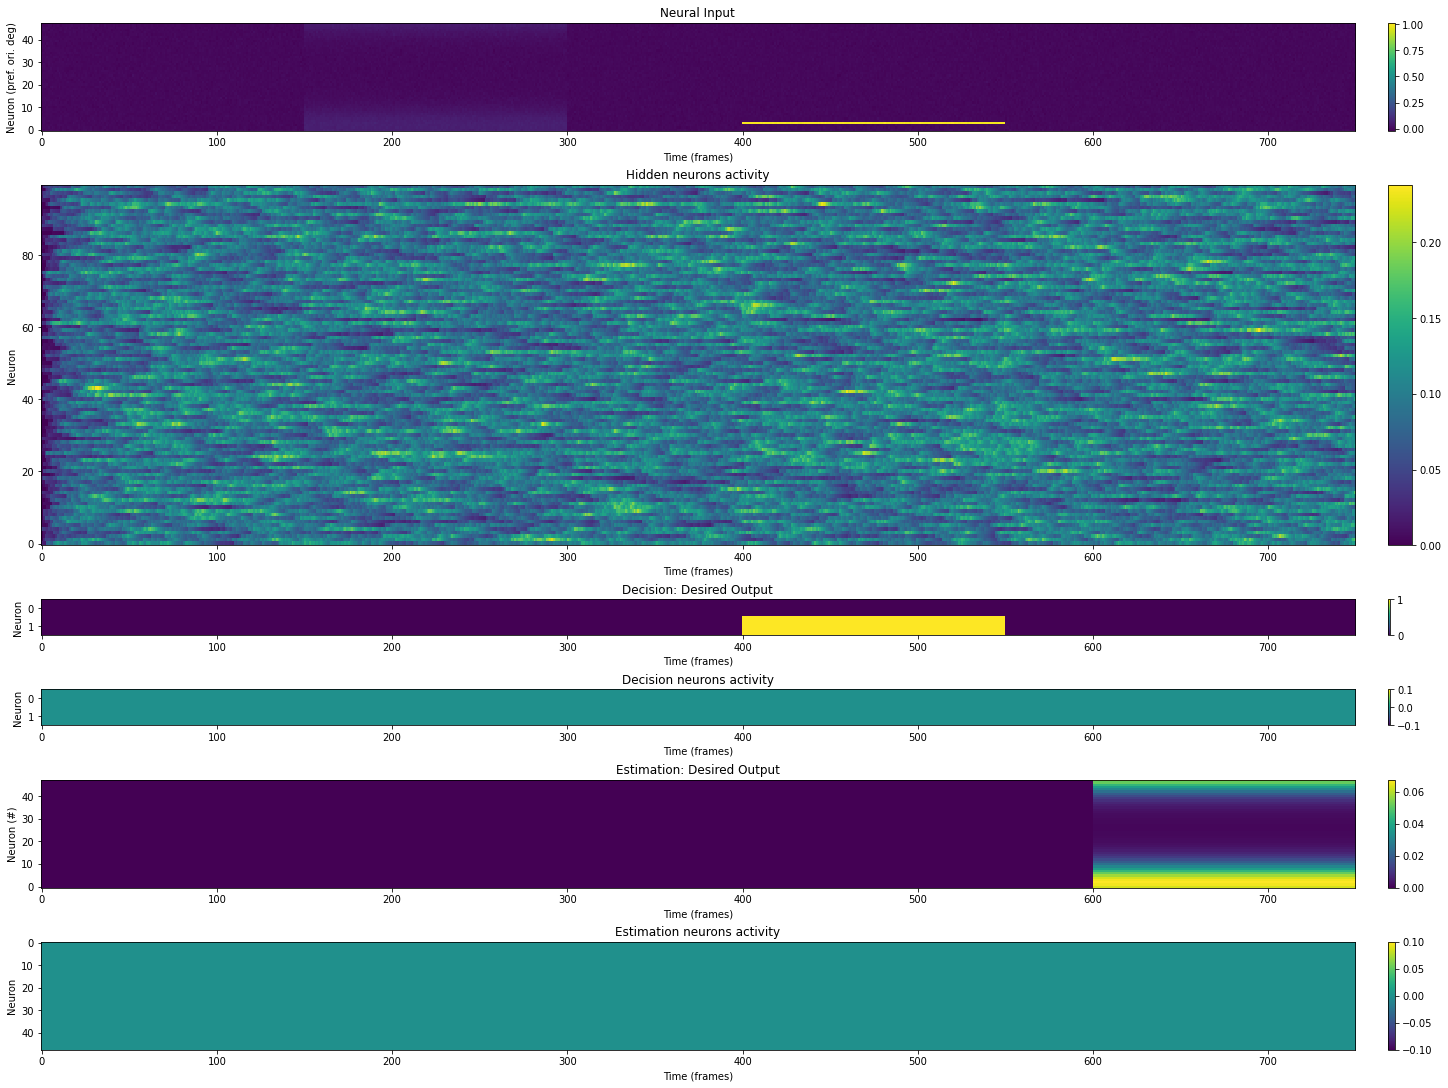

 601/1000 [=================>............] - ETA: 3858s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6486 - Test decision performance: : 0.5781 - Grads: 0.7597


 Epoch 602, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter601/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter601/assets


<Figure size 432x288 with 0 Axes>

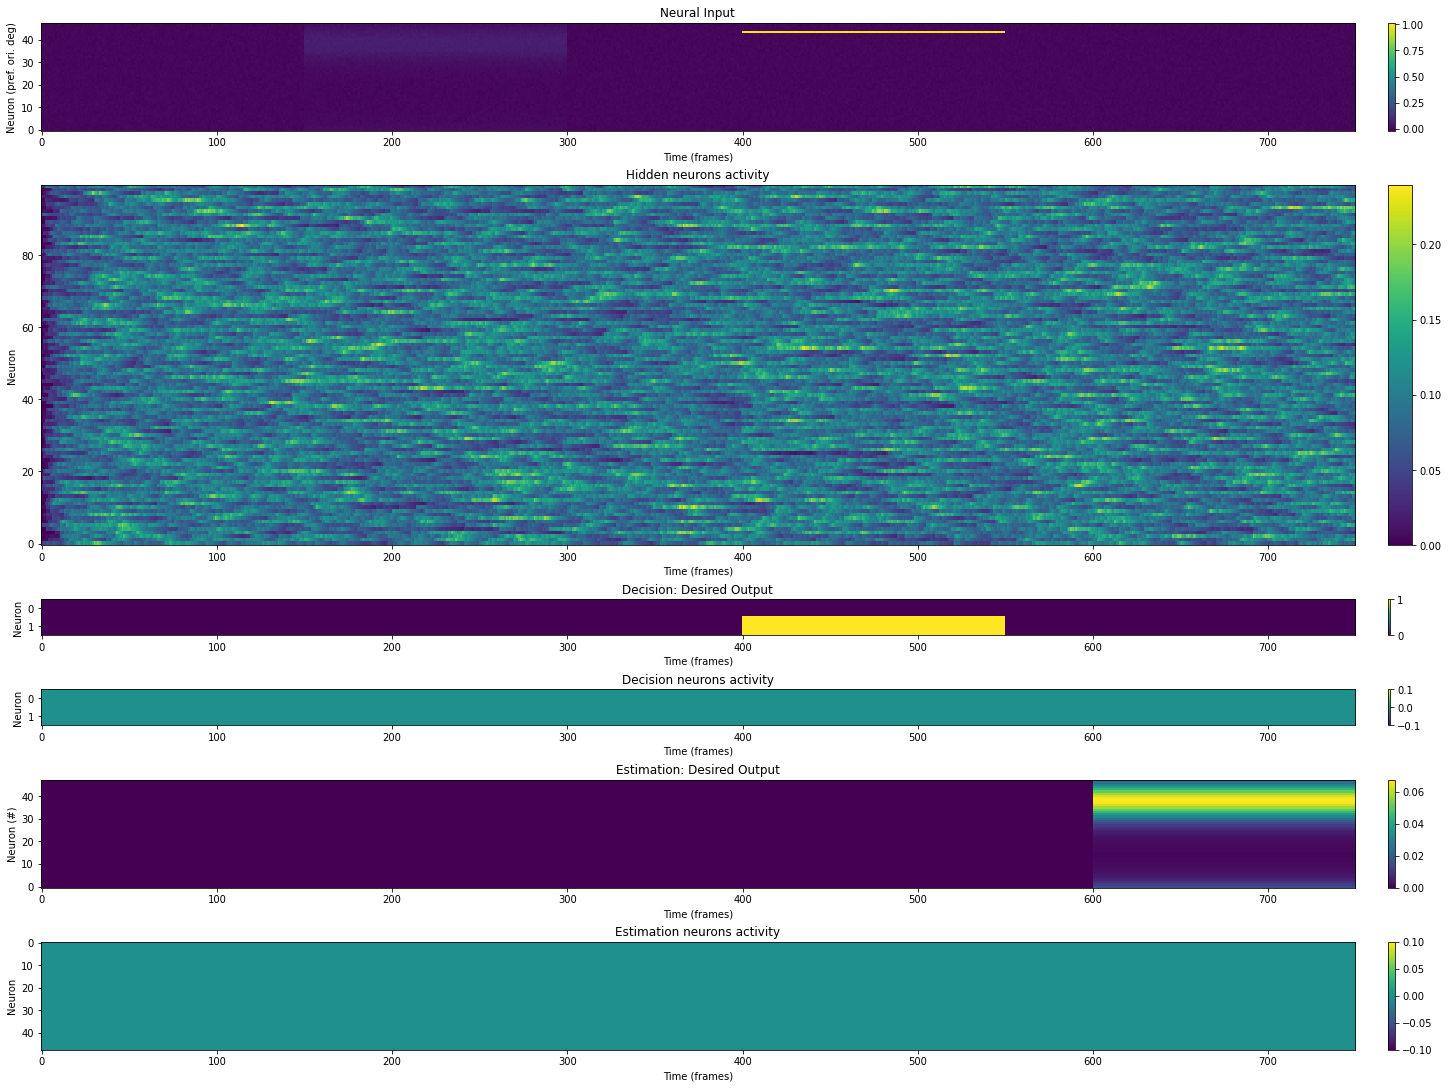

 701/1000 [====================>.........] - ETA: 2954s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.5500 - Test decision performance: : 0.5000 - Grads: 0.7597


 Epoch 702, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter701/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter701/assets


<Figure size 432x288 with 0 Axes>

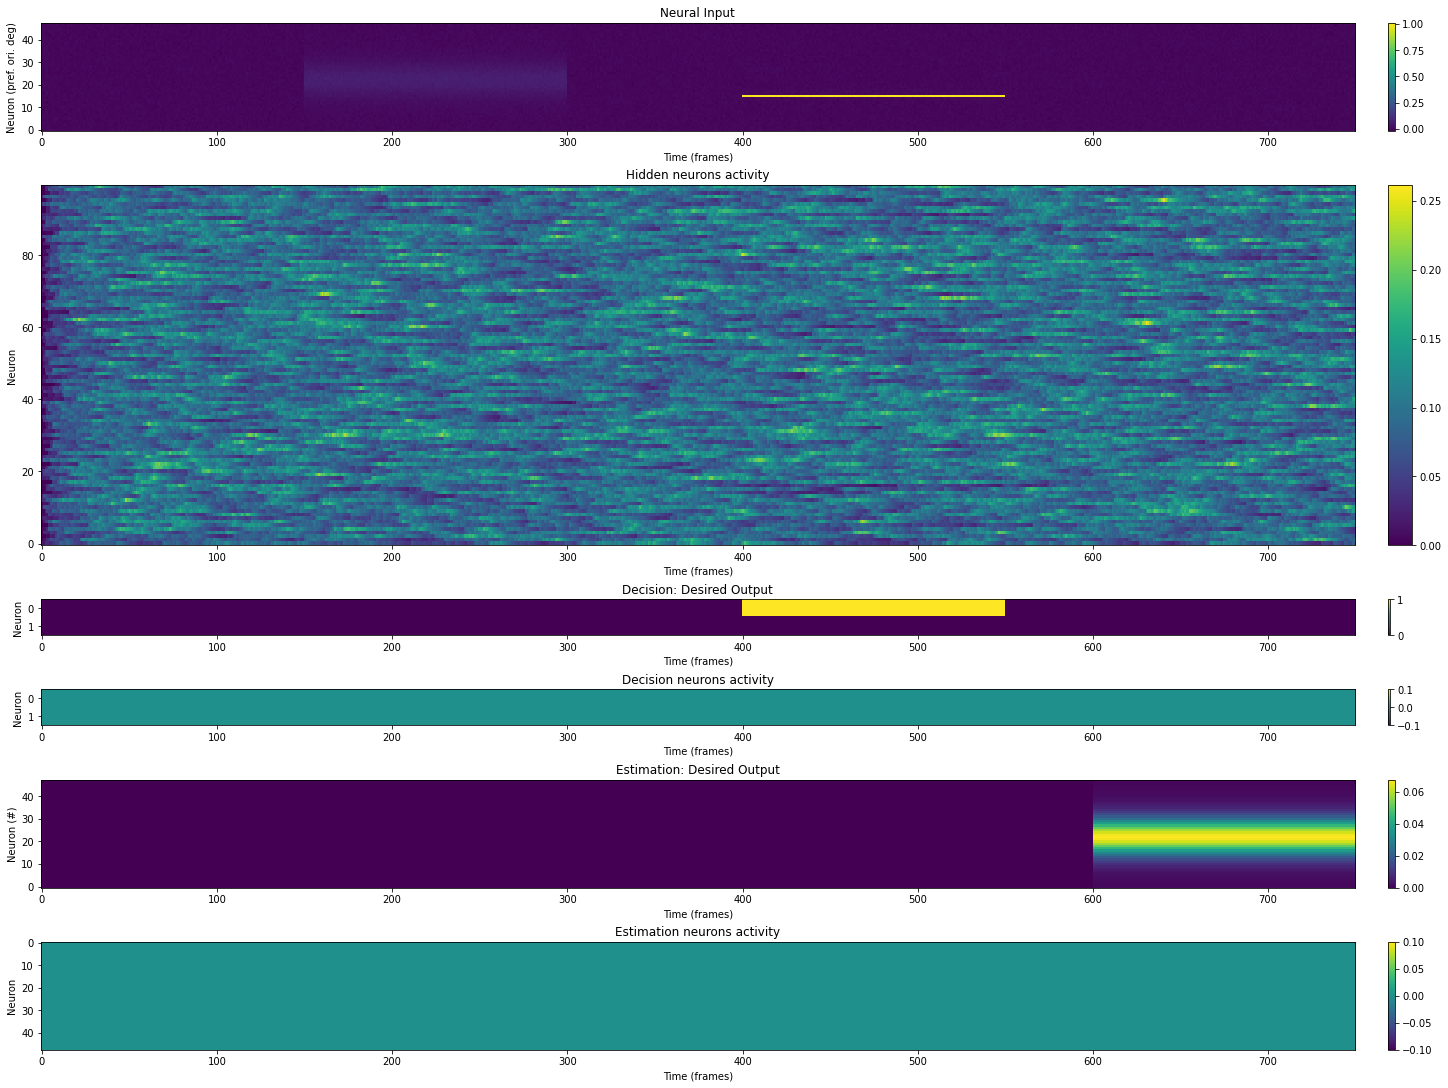

 801/1000 [=======================>......] - ETA: 2051s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6596 - Test decision performance: : 0.4297 - Grads: 0.7597


 Epoch 802, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter801/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter801/assets


<Figure size 432x288 with 0 Axes>

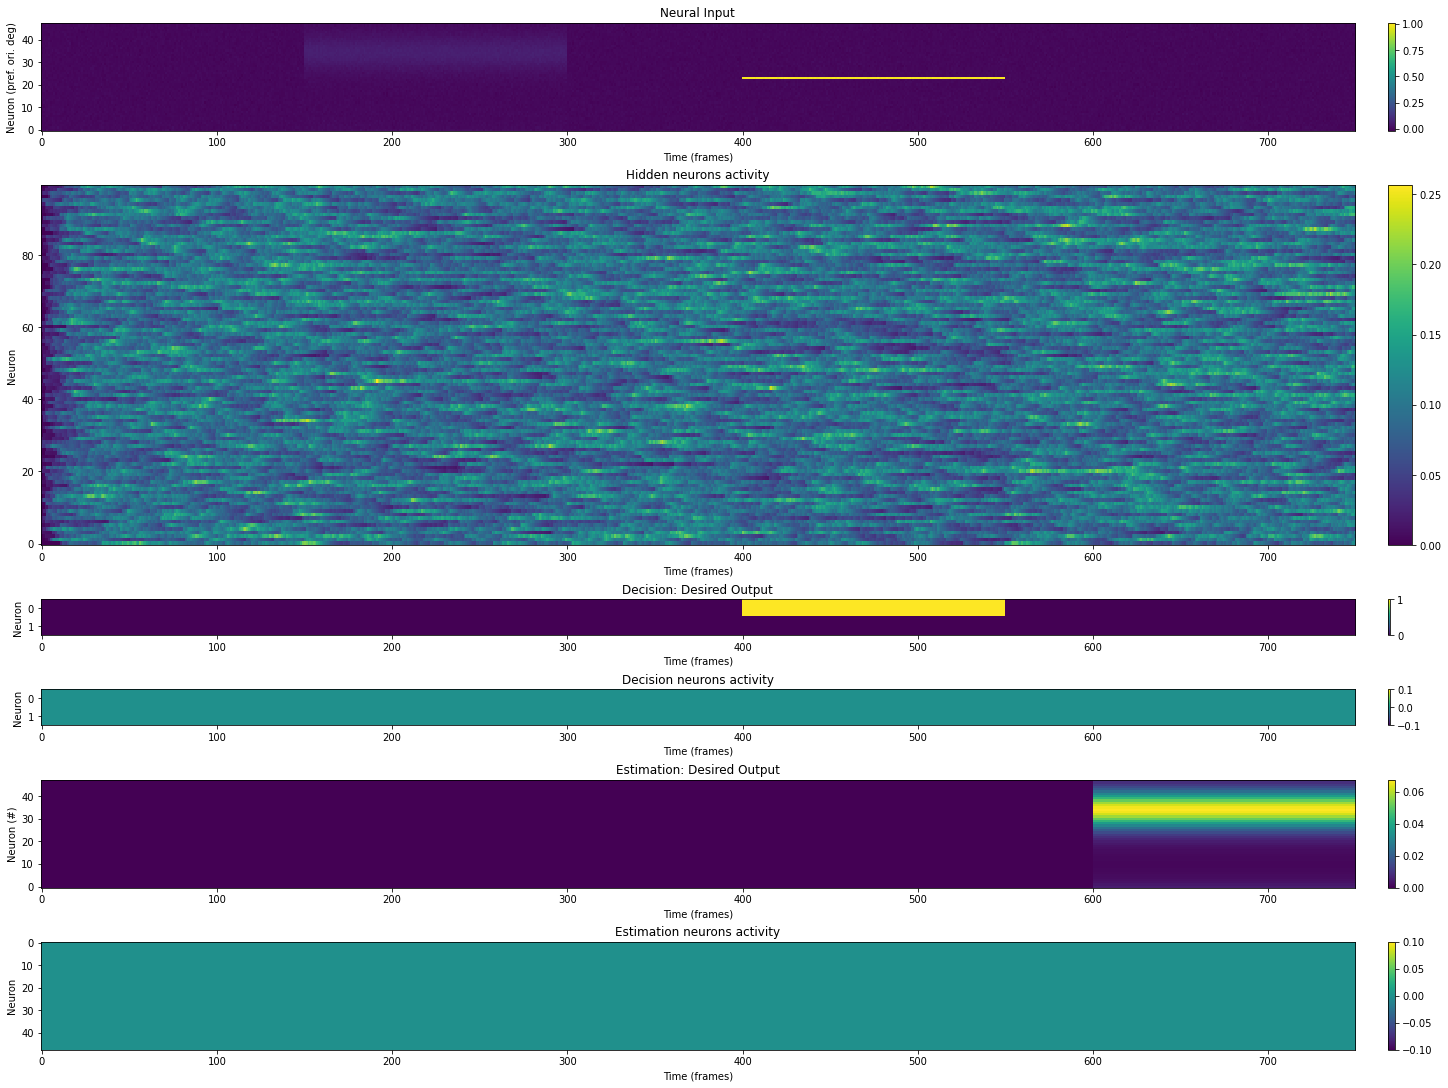

 901/1000 [==========================>...] - ETA: 1040s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6126 - Test decision performance: : 0.5781 - Grads: 0.7597


 Epoch 902, Train Loss: 456.5329895019531, Test Loss: 456.5329895019531


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter901/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn/model9/model/iter901/assets


<Figure size 432x288 with 0 Axes>

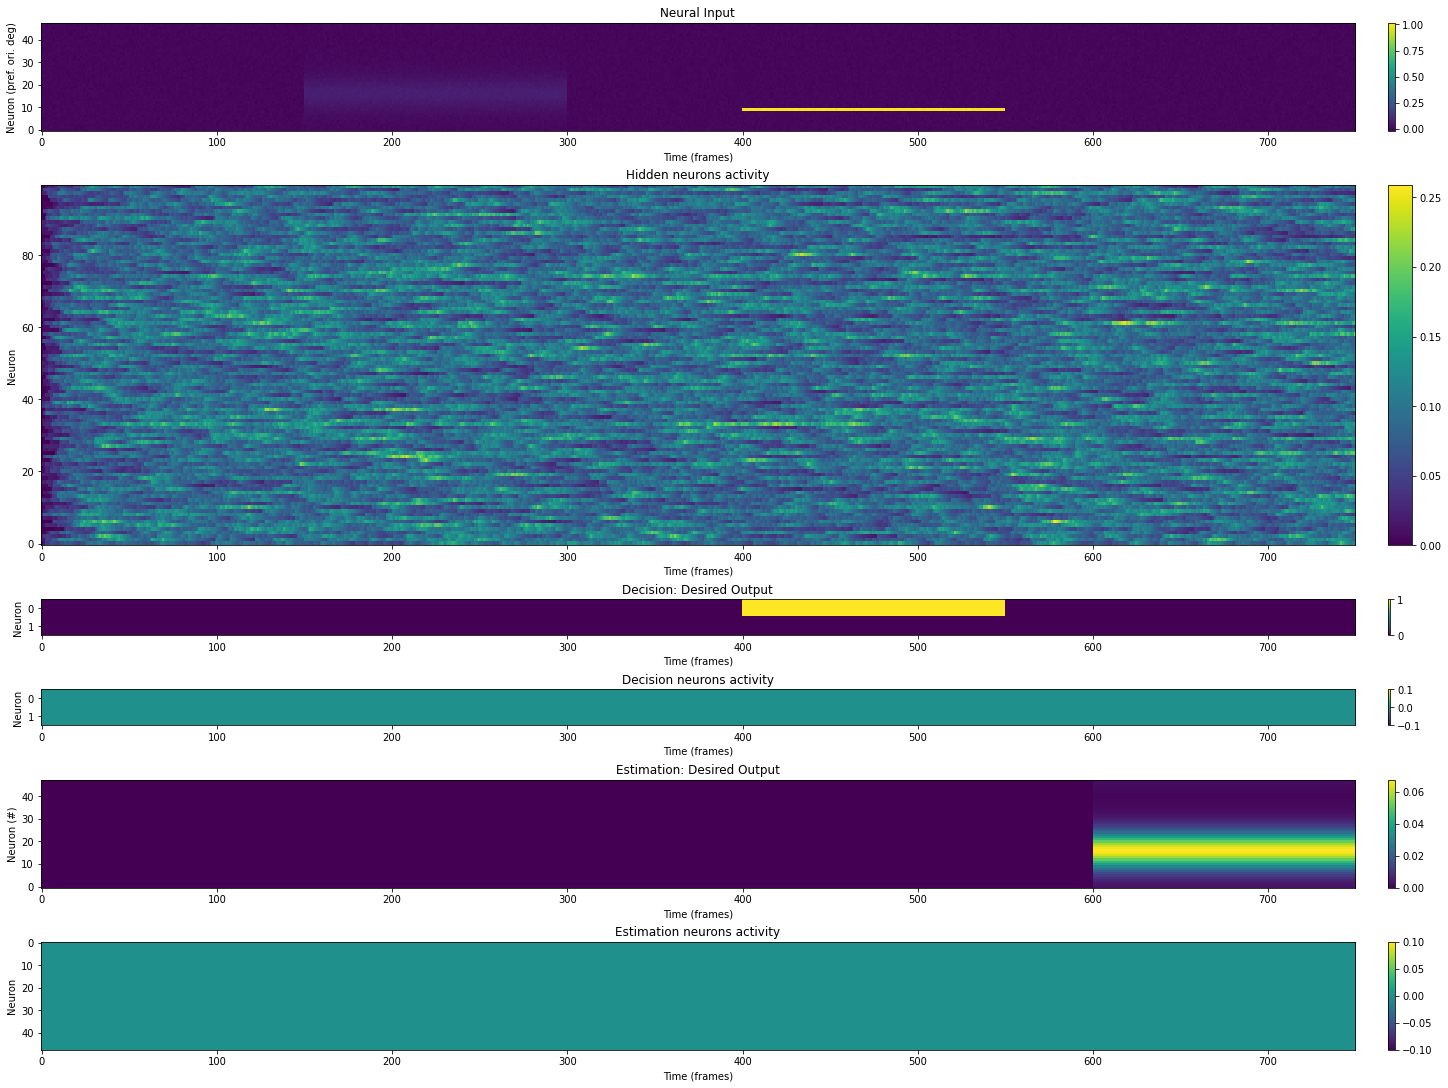

 935/1000 [===========================>..] - ETA: 681s - Train Loss: 456.5330 - Test Loss: 456.5330 - Test estimation cos error: : 0.6259 - Test decision performance: : 0.5312 - Grads: 0.7597

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [14]:
# train network
grnn9.train(stim_train = stim_train, stim_test= stim_train, niter=1000)

In [ ]:
# evaluate and visualize after training
test_lossStruct, test_outputs   = grnn9.evaluate(test_data)

# plot rnn trial and outputs
TEST_TRIAL = np.random.randint(stim_train.batch_size) 
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

# plot rnn decision effects on estimation
df_trials, df_sum = estimation_decision(test_data, test_outputs, stim_test)
plot_decision_effects(df_trials,df_sum)

# model 8: with stsp
- relu(tanh()) activation
- gated outputs (dm and em)

In [ ]:
hp10    = copy.deepcopy(grnn_hp)
hp10['output_path'] = '/Users/JRyu/github/det_rnn/experiments/grnn/model10/'
hp10['model_output'] = '/Users/JRyu/github/det_rnn/experiments/grnn/model10/model'
hp10['log_path'] = '/Users/JRyu/github/det_rnn/experiments/grnn/model10/logs'
hp10['learning_rate'] = 0.05
hp10['neuron_stsp'] = True
hp10['out_gate'] = True
hp10['loss_ce_dec'] = 100
hp10['loss_ce_est'] = 100
grnn10  = gRNN(hp10, par_train)

In [ ]:
# evaluate and visualize before training
test_lossStruct, test_outputs   = grnn10.evaluate(test_data)

# plot rnn trial and outputs
TEST_TRIAL = np.random.randint(stim_train.batch_size) 
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

# plot rnn decision effects on estimation
df_trials, df_sum = estimation_decision(test_data, test_outputs, stim_test)
plot_decision_effects(df_trials,df_sum)

In [ ]:
grnn10.train(stim_train = stim_train, stim_test= stim_train, niter=1000)

In [ ]:
### evaluate and visualize before training
test_lossStruct, test_outputs   = grnn10.evaluate(test_data)

# plot rnn trial and outputs
TEST_TRIAL = np.random.randint(stim_train.batch_size) 
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

# plot rnn decision effects on estimation on test set
df_trials, df_sum = estimation_decision(test_data, test_outputs, stim_test)
plot_decision_effects(df_trials,df_sum)